### Data Mining on Hospital Dataset

This notebook looks at the Hospital dataset and builds a model to predict the onset of diabetes

### Imports

In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import matplotlib.patches as mpatches
from IPython.display import HTML
from operator import itemgetter


import pandas as pd
import numpy as np


# pd.options.mode.chained_assignment = None 

### Helper functions

In [65]:
def print_bold(text):
    display(Markdown("**{}**".format(text)))
    
def print_color(text, color='red'):
    display(HTML("<text style=color:{}>{}</text>".format(color, text)))


def display_confusion_matrix(target_test, target_predict):
    print_bold('Confusion Matrix')
    y_actu = pd.Series(target_test, name='Actual')
    y_pred = pd.Series(target_predict, name='Predicted')
    print(pd.crosstab(y_actu, y_pred))
    
# Basic graph plotting utility
def plot_roc_curve(confusion_matrix_list, models, x_label, y_label, model_names=''):
    
    tpr_fpr_list = []
    
    for cm in confusion_matrix_list:
    
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
    
        
        tpr_fpr_list.append((round(fpr, 2), round(tpr , 2)))
        
    tpr_fpr_list.sort(key=itemgetter(1))    
    handles = []
    
    for model_name, model, color in models:
        patch = mpatches.Patch(color=color, label=model_name)
        handles.append(patch)
        
    fpr_list, tpr_list = zip(*tpr_fpr_list)
    
    fig, ax = plt.subplots()
    plt.plot(fpr_list, tpr_list, 'bs-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    for idx, _   in enumerate(tpr_list):
        
        tpr = tpr_list[idx]
        fpr = fpr_list[idx]
#         plt.plot([fpr, fpr], [0, tpr], 'ks-') # vertical
#         plt.plot([0, fpr], [tpr, tpr], 'ks-') # horizontal
        plt.plot([fpr], [tpr], marker='o',  markersize=10, color=models[idx][2])
    plt.legend(handles=handles)
    plt.show()

### Read dataset

In [66]:
DATASET_NAME = 'dataset/diabetes_hospital.csv'
df = pd.read_csv(DATASET_NAME)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Find out missing values in the dataset

In [67]:
attributes = ['race', 'gender', 'age', 'medical_specialty','change','diabetesMed', 'readmitted']
for attr in attributes:
    print(attr,": ", sum(df[attr] == '?'))

race :  2273
gender :  0
age :  0
medical_specialty :  49949
change :  0
diabetesMed :  0
readmitted :  0


### Show statistics of the dataset

In [68]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


### Drop columns
Drop attributes like IDs and other irrelevant attributes

In [69]:
bad_features = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'admission_type_id', 
                'discharge_disposition_id', 'admission_source_id', 'number_outpatient', 'number_emergency', 
                'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'examide', 
                'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'max_glu_serum', 'A1Cresult', 
                'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
                'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton']
df.drop(bad_features, inplace=True, axis =1)

### Replace missing values

In [70]:
df['medical_specialty'] = df['medical_specialty'].replace(['?', ''], 'General')
df['race'] = df['race'].replace(['?', ''], 'Other')
df['readmitted'] = df['readmitted'].replace(['>30', '<30'], 'YES')
df

,race,gender,age,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,insulin,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),1,Pediatrics-Endocrinology,41,0,1,No,No,No,NO
1,Caucasian,Female,[10-20),3,General,59,0,18,Up,Ch,Yes,YES
2,AfricanAmerican,Female,[20-30),2,General,11,5,13,No,No,Yes,NO
3,Caucasian,Male,[30-40),2,General,44,1,16,Up,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,General,51,0,8,Steady,Ch,Yes,NO
5,Caucasian,Male,[50-60),3,General,31,6,16,Steady,No,Yes,YES
6,Caucasian,Male,[60-70),4,General,70,1,21,Steady,Ch,Yes,NO
7,Caucasian,Male,[70-80),5,General,73,0,12,No,No,Yes,YES
8,Caucasian,Female,[80-90),13,General,68,2,28,Steady,Ch,Yes,NO
9,Caucasian,Female,[90-100),12,InternalMedicine,33,3,18,Steady,Ch,Yes,NO


### One Hot Encoding

In [71]:
dummy_columns = ['race', 'gender','age', 'insulin', 'change', 'medical_specialty', 'diabetesMed']
df_dummies = pd.get_dummies(df, columns=dummy_columns)

In [72]:
df_target = df_dummies['readmitted']

# Drop the target variable from dataframe
df_dummies.drop('readmitted' , inplace = True, axis =1)
df_attr = df_dummies
df_attr.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,...,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Pediatric,medical_specialty_Surgery-Plastic,medical_specialty_Surgery-PlasticwithinHeadandNeck,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,3,59,0,18,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,2,11,5,13,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,2,44,1,16,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,51,0,8,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Split attribues for training and testing

In [73]:
attr_train, attr_test, target_train, target_test = train_test_split(df_attr , df_target)

### Models
Fit various models and check results

In [74]:
models = [('Decision Tree', DecisionTreeClassifier(max_depth= 5), 'red'), 
          ('Logistic Regression', LogisticRegression(), 'green'), 
          ('Random Forest', RandomForestClassifier(), 'yellow')]

predicted_results = []
for model_names, model, _ in models:
    model.fit(attr_train, target_train)
    target_predict = model.predict(attr_test)
    predicted_results.append(target_predict)

### Results
Show the results of various models

In [75]:
fpr_list = []
tpr_list = []
confusion_matrix_list = []

for idx, (model_name, model, _) in enumerate(models):
    print_color(model_name)
    print_bold('Accuracy Score')
    print(accuracy_score(target_test.values, predicted_results[idx]), end='\n\n')
    
    display_confusion_matrix(target_test.values, predicted_results[idx])
    cm = confusion_matrix(target_test, predicted_results[idx])
    confusion_matrix_list.append(cm)
    
    print_bold('Classification Report')
    print(classification_report(target_test, predicted_results[idx]))

**Accuracy Score**

0.559272069806



**Confusion Matrix**

Predicted     NO   YES
Actual                
NO         10588  3110
YES         8103  3641


**Classification Report**

             precision    recall  f1-score   support

         NO       0.57      0.77      0.65     13698
        YES       0.54      0.31      0.39     11744

avg / total       0.55      0.56      0.53     25442



**Accuracy Score**

0.565089222545



**Confusion Matrix**

Predicted    NO   YES
Actual               
NO         9744  3954
YES        7111  4633


**Classification Report**

             precision    recall  f1-score   support

         NO       0.58      0.71      0.64     13698
        YES       0.54      0.39      0.46     11744

avg / total       0.56      0.57      0.55     25442



**Accuracy Score**

0.537221916516



**Confusion Matrix**

Predicted    NO   YES
Actual               
NO         9078  4620
YES        7154  4590


**Classification Report**

             precision    recall  f1-score   support

         NO       0.56      0.66      0.61     13698
        YES       0.50      0.39      0.44     11744

avg / total       0.53      0.54      0.53     25442



### Analysis

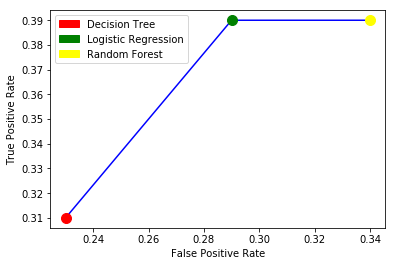

In [76]:
plot_roc_curve(confusion_matrix_list, models, 'False Positive Rate', 'True Positive Rate')